In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(69)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
# train = pd.read_csv('./new_train.csv')
train = pd.read_csv('./input/new_train_combine_3.csv')
# train = pd.read_csv('./new_train_combined_date_trap.csv') # saved one without species but no NaNs

In [4]:
train.isna().sum().sum()

0

In [5]:
test = pd.read_csv('./input/new_test.csv')

In [6]:
train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'index'], axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
mask = train['WnvPresent'] > 1

In [8]:
train['WnvPresent'].loc[mask] = 1

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
train['WnvPresent'].value_counts()[0]/sum(train['WnvPresent'].value_counts())

0.9460766961651917

# Created new Target Variable based on number of mosquitos OR West Nile detected

In [10]:
new_dum = []
for i in range(len(train['WnvPresent'])):
    if train['WnvPresent'][i] == 1 or train['NumMosquitos'][i] > 14:
        n = 1
    else:
        n = 0
    new_dum.append(n)

In [11]:
train['new_dum'] = new_dum

In [12]:
train['new_dum'].value_counts()[0]/sum(train['new_dum'].value_counts())

0.7847787610619469

Lowered majority population from 94.60% to 78.4%

In [13]:
test.drop('Id', axis=1, inplace=True)

In [14]:
y = train.new_dum

In [15]:
X = train[[col for col in train.columns if col != 'new_dum']]

In [16]:
X['Sunlight'] = X['Sunset'] - X['Sunrise']

In [17]:
test['Sunlight'] = test['Sunset'] - test['Sunrise']

In [18]:
X['temp_range'] = X['Tmax'] - X['Tmin']
test['temp_range'] = test['Tmax'] - test['Tmin']

In [19]:
X['Date'] = pd.to_datetime(X['Date'], utc=True)
test['Date'] = pd.to_datetime(test['Date'], utc=True)

-----------------------------------------------

In [20]:
def make_date_float(d):
    return d.timestamp()
X['Date'] = [make_date_float(n) for n in X['Date']]
test['Date'] = [make_date_float(n) for n in test['Date']]

In [21]:
X.drop(['Address','AddressAccuracy', 'Street','AddressNumberAndStreet', 'Block', 'Sunrise','Sunset', 'NumMosquitos', 'WnvPresent', 'Tmax','Tmin'], axis=1, inplace=True)
test.drop(['Address','AddressAccuracy', 'Street','AddressNumberAndStreet', 'Block', 'Sunrise','Sunset', 'Tmax', 'Tmin'], axis=1, inplace=True)

In [22]:
def direction(d):
    if d > 315 or d <= 45:
        x = 'N'
    elif d > 45 and d <= 135:
        x = 'E'
    elif d > 135 and d <= 225:
        x = 'S'
    elif d > 225 and d <= 315:
        x = 'W'
    return x

In [23]:
ResultDir_dum = []
for i in range(len(X['ResultDir'])):
    z = direction(X['ResultDir'][i])
    ResultDir_dum.append(z)
    
X['ResultDir_dum'] = ResultDir_dum

In [24]:
ResultDir_dum2 = []
for i in range(len(test['ResultDir'])):
    z = direction(test['ResultDir'][i])
    ResultDir_dum2.append(z)
    
test['ResultDir_dum'] = ResultDir_dum2

In [25]:
X.drop('ResultDir', axis=1, inplace=True)
test.drop('ResultDir', axis=1, inplace=True)

In [26]:
def get_dummied(train, test):
    list = []
    for i in train.columns:
        if train[i].dtype == object:
            list.append(i)
            
    full_data = pd.concat([train, test], axis=0)
    full_data = pd.get_dummies(full_data, columns=list, drop_first=True)
    
    X_dummied = full_data[:len(train)]
    test_dummied = full_data[len(train):]

    return X_dummied, test_dummied 

In [27]:
X, test = get_dummied(X, test)

In [28]:
test.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

---------------------

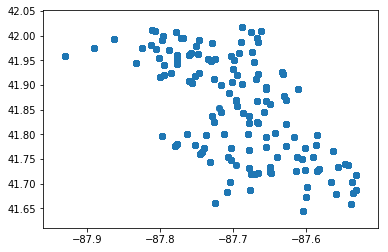

In [29]:
plt.scatter(X.Longitude, X.Latitude);

In [30]:
geo = pd.DataFrame()
geo['long']=X.Longitude
geo['lat']=X.Latitude
geo.head(3)

,long,lat
0,-87.800991,41.954690
1,-87.800991,41.954690
2,-87.769279,41.994991


In [31]:
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(geo)
labels = model.labels_

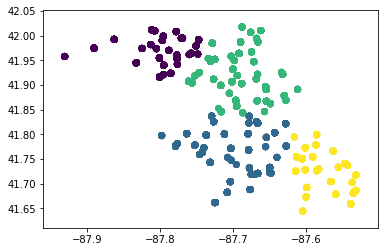

In [32]:
plt.scatter(geo.long, geo.lat, c=labels);

In [33]:
X['geo_zone'] = labels

In [34]:
test_geo = pd.DataFrame()
test_geo['long']=test.Longitude
test_geo['lat']=test.Latitude
test_geo.head(3)

,long,lat
0,-87.800991,41.95469
1,-87.800991,41.95469
2,-87.800991,41.95469


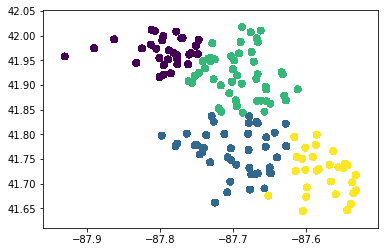

In [35]:
plt.scatter(test_geo.long, test_geo.lat, c=model.predict(test_geo));

In [36]:
test['geo_zone'] = model.predict(test_geo)

In [37]:
X_geo_dums = pd.get_dummies(X.geo_zone)
test_geo_dums = pd.get_dummies(test.geo_zone)

In [38]:
X = pd.concat([X_geo_dums, X], axis=1)

In [39]:
test = pd.concat([test_geo_dums, test], axis=1)

In [40]:
X.drop(['Latitude', 'Longitude', 'geo_zone'], axis=1, inplace=True)
test.drop(['Latitude', 'Longitude', 'geo_zone'], axis=1, inplace=True)

In [41]:
 pd.options.display.max_columns = 999

In [42]:
X.head(3)

,0,1,2,3,Date,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,RA_yes,BR_yes,TS_yes,HZ_yes,DZ_yes,Sunlight,temp_range,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,Trap_T002,Trap_T002A,Trap_T002B,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T065A,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T090A,Trap_T090B,Trap_T090C,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T128A,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T200A,Trap_T200B,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T218A,Trap_T218B,Trap_T218C,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,0.0,29.415001,30.1,5.8,6.95,0.0,1.0,0.0,1.0,0.0,1496.0,25.5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,0.0,29.415001,30.1,5.8,6.95,0.0,1.0,0.0,1.0,0.0,1496.0,25.5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,0.0,29.415001,30.1,5.8,6.95,0.0,1.0,0.0,1.0,0.0,1496.0,25.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
test.head(3)

,0,1,2,3,Date,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,RA_yes,BR_yes,TS_yes,HZ_yes,DZ_yes,Sunlight,temp_range,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,Trap_T002,Trap_T002A,Trap_T002B,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T065A,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T090A,Trap_T090B,Trap_T090C,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T128A,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T200A,Trap_T200B,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T218A,Trap_T218B,Trap_T218C,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,0.0,29.310001,29.98,9.15,10.2,0.0,0.0,0.0,0.0,0.0,1510.0,22.5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,0.0,29.310001,29.98,9.15,10.2,0.0,0.0,0.0,0.0,0.0,1510.0,22.5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,0.0,29.310001,29.98,9.15,10.2,0.0,0.0,0.0,0.0,0.0,1510.0,22.5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


------------------

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [45]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

--------------------------------------

# Start of model building

In [51]:
lg = LogisticRegression()

In [52]:
lg_params = {"penalty" : ['l1', 'l2'], "tol" : [.0001, .001, .01, .1, 1], "C" : [1, .5, .1, .01]}

lg_gs = GridSearchCV(lg, lg_params, scoring='recall')

In [53]:
lg_gs.fit(X_train, y_train)
print("Training data:", lg_gs.score(X_train, y_train))
print("Test data:", lg_gs.score(X_test, y_test))

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-

Training data: 0.6161137440758294
Test data: 0.4444444444444444


In [54]:
lg_gs.best_params_

{'C': 0.5, 'penalty': 'l2', 'tol': 0.01}

In [55]:
sum(lg_gs.predict(test))

116293